In [1]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import itertools
import os
import zipfile
import random
import numpy as np

import requests
import matplotlib.pyplot as plt

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Layer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Read data

In [2]:
df_movies = pd.read_csv("data/movies_cast_company.csv", encoding='utf8')
df_movies["cast"] = df_movies["cast"].apply(lambda x: json.loads(x))
df_movies["company"] = df_movies["company"].apply(lambda x: json.loads(x))

# TODO: just temporary, later remove
df_movies = df_movies.drop(["url"]+list(df_movies.columns[-4:]), axis=1)

print(df_movies.shape)
df_movies.head()

(1315, 22)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [3]:
def string2ts(string, fmt="%Y-%m-%d %H:%M:%S"):
    dt = datetime.datetime.strptime(string, fmt)
    t_tuple = dt.timetuple()
    return int(time.mktime(t_tuple))

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")

df_ratings.rating_timestamp = df_ratings.rating_timestamp.apply(lambda x: string2ts(x))

print(df_ratings.shape)
df_ratings.head()

(100000, 4)


,user_id,movie_id_ml,rating,rating_timestamp
0,196,242,3,881247349
1,186,302,3,891710542
2,22,377,1,878883516
3,244,51,2,880603323
4,166,346,1,886393996


In [5]:
df_users = pd.read_csv("data/users.csv")

# TODO: just temporary, later remove
additional_rows = ["user_zipcode"]
df_users = df_users.drop(additional_rows, axis=1)

num2occupation = dict(enumerate(df_users.user_occupation.unique()))
occupation2num = {y:x for x,y in num2occupation.items()}
num2gender = dict(enumerate(df_users.user_gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
df_users.user_occupation = df_users.user_occupation.apply(lambda x: occupation2num[x])
df_users.user_gender = df_users.user_gender.apply(lambda x: gender2num[x])


print(df_users.shape)
df_users.head()

(943, 4)


,user_id,user_age,user_gender,user_occupation
0,1,24,0,0
1,2,53,1,1
2,3,23,0,2
3,4,24,0,0
4,5,33,1,1


##### All

In [6]:
df = pd.merge(df_movies, df_ratings, on="movie_id_ml")
df = pd.merge(df, df_users, on="user_id")

print(df.shape)
df.head()

(90851, 28)


,movie_id_ml,title,release,unknown,action,adventure,animation,childrens,comedy,crime,...,scifi,thriller,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation
0,1,toy story,1995,0,0,0,1,1,1,0,...,0,0,0,0,308,4,887732932,60,0,18
1,4,get shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,308,5,887734290,60,0,18
2,5,copycat,1995,0,0,0,0,0,0,1,...,0,1,0,0,308,4,887736008,60,0,18
3,7,twelve monkeys,1995,0,0,0,0,0,0,0,...,1,0,0,0,308,4,887735247,60,0,18
4,8,babe,1995,0,0,0,0,1,1,0,...,0,0,0,0,308,5,887733096,60,0,18


In [7]:
# movies
id2movie = dict(enumerate(df.movie_id_ml.unique()))
movie2id = {y:x for x,y in id2movie.items()}

# users
id2user = dict(enumerate(df.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

# Friends
def slice_by_lengths(lengths, the_list):
    for length in lengths:
        new = []
        for i in range(length):
            new.append(the_list.pop(0))
        yield new
        
user_ids = list(df_users.user_id.unique())
total_users = len(user_ids)
lengths_sum = 0
lengths = []

for i in range(total_users):
    length = random.randint(2, 8)
    
    if lengths_sum+length > total_users:
        length = total_users - lengths_sum
        lengths_sum += length
        lengths.append(length)
        break
    elif lengths_sum+length == total_users:
        lengths_sum += length
        lengths.append(length)
        break
    else:
        lengths_sum += length
        lengths.append(length)
        
friend_ids = [i for i in enumerate(slice_by_lengths(lengths, user_ids))]
print(f"Number of friend groupd: {len(friend_ids)}, max {max(friend_ids)[0]}")

user2friendsid = {}
for fid_and_uids in friend_ids:
    for uid in fid_and_uids[1]:
        user2friendsid[uid] = fid_and_uids[0]


Number of friend groupd: 190, max 189


In [8]:
df["iid"] = df.apply(lambda x: movie2id[x.movie_id_ml], axis=1)
df["uid"] = df.apply(lambda x: user2id[x.user_id], axis=1)
df["fid"] = df.apply(lambda x: user2friendsid[x.user_id], axis=1)

In [9]:
fid2avgage = dict(df.groupby("fid")["user_age"].agg(np.mean))
fid2medianrating = dict(df.groupby(["fid","iid"])["rating"].agg(np.median))

In [10]:
df["fid_user_avg_age"] = df.apply(lambda x: fid2avgage[x.fid], axis=1)
df["rating"] = df.apply(lambda x: fid2medianrating[(x.fid, x.iid)], axis=1)

In [11]:
df = df.drop(["uid", "user_gender", "user_occupation", "user_age", "user_id", "rating_timestamp"], axis=1)

In [12]:
df.shape

(90851, 26)

In [13]:
df = df.drop_duplicates()

In [14]:
df.shape

(59845, 26)

##### Prepare for new user

In [17]:
# shape [n_users, n_user_features]
df_friends = df[["fid", "fid_user_avg_age"]].drop_duplicates()
print(f"Number of friends features: {df_friends.shape[0]}")

df_movies = df[["iid"]+list(df.columns[3:22])].drop_duplicates()
print(f"Number of movies features: {df_movies.shape[0]}")

Number of friends features: 190
Number of movies features: 1280


---

# Simulate our user input

First, `user_movie_ratings_training` is used to simulate initial user input that we will ask him to rate some random movies. Later, we will try to recommend movies to him, but we know what is his preference thanks to `user_movie_ratings_test`. Both lists are extracted from the existed dataset.

<div class="alert alert-success">
  <strong>Note:</strong> The next cell info will be extracted from the web app input from users.
</div>

In [18]:
columns = ["fid", "iid", "rating", "fid_user_avg_age"]

# friends info
friends_age = 30.125
friends_id = len(friend_ids)
print(friends_id)

# iid, rating
friends_movie_ratings_training = [[0.0, 5.0],
 [3.0, 4.0],
 [47.0, 4.0],
 [51.0, 4.0],
 [61.0, 4.0],
 [333.0, 2.0],
 [119.0, 4.0],
 [486.0, 4.0],
 [123.0, 3.0],
 [133.0, 4.0],
 [135.0, 5.0],
 [488.0, 4.5],
 [539.0, 2.0],
 [180.0, 4.5],
 [490.0, 3.5],
 [369.0, 4.0],
 [373.0, 5.0],
 [5.0, 3.0],
 [6.0, 5.0],
 [814.0, 4.0],
 [10.0, 4.0],
 [12.0, 4.5],
 [378.0, 3.0],
 [983.0, 4.0],
 [17.0, 4.5],
 [779.0, 1.0],
 [379.0, 3.0],
 [18.0, 4.0],
 [19.0, 5.0],
 [20.0, 4.0],
 [380.0, 3.0],
 [21.0, 5.0],
 [381.0, 4.0],
 [24.0, 4.0],
 [25.0, 5.0],
 [28.0, 2.0],
 [29.0, 3.0],
 [382.0, 4.0],
 [31.0, 5.0],
 [383.0, 2.0],
 [39.0, 5.0],
 [386.0, 4.0],
 [41.0, 4.0],
 [42.0, 3.5],
 [43.0, 5.0],
 [332.0, 4.0],
 [49.0, 1.0],
 [52.0, 5.0],
 [55.0, 3.0],
 [68.0, 4.0],
 [360.0, 5.0],
 [73.0, 4.5],
 [79.0, 5.0],
 [81.0, 2.0],
 [82.0, 5.0],
 [83.0, 5.0],
 [782.0, 4.0],
 [86.0, 4.5],
 [87.0, 5.0],
 [88.0, 4.0],
 [89.0, 5.0],
 [92.0, 4.0],
 [93.0, 5.0],
 [94.0, 2.0],
 [96.0, 3.0],
 [97.0, 5.0],
 [100.0, 4.0],
 [101.0, 5.0],
 [102.0, 4.0],
 [103.0, 4.0],
 [104.0, 4.0],
 [106.0, 4.0],
 [362.0, 1.0],
 [363.0, 3.0],
 [400.0, 2.0],
 [107.0, 1.0],
 [108.0, 2.0],
 [401.0, 4.0],
 [109.0, 5.0],
 [110.0, 3.5],
 [112.0, 4.0],
 [114.0, 5.0],
 [124.0, 3.0],
 [487.0, 4.0],
 [403.0, 5.0],
 [128.0, 2.0],
 [138.0, 4.0],
 [142.0, 4.0],
 [145.0, 4.0],
 [502.0, 3.0],
 [147.0, 4.0],
 [506.0, 1.0],
 [508.0, 2.0],
 [149.0, 2.0],
 [513.0, 1.0],
 [515.0, 1.0],
 [151.0, 2.0],
 [152.0, 4.0],
 [416.0, 4.0],
 [516.0, 3.0],
 [518.0, 2.0],
 [520.0, 1.0],
 [157.0, 2.0],
 [159.0, 4.0],
 [344.0, 4.0],
 [161.0, 4.5],
 [419.0, 4.0],
 [168.0, 2.0],
 [171.0, 1.0],
 [531.0, 1.0],
 [422.0, 2.0],
 [818.0, 4.0],
 [177.0, 5.0],
 [188.0, 5.0],
 [423.0, 5.0],
 [216.0, 4.0],
 [819.0, 4.0],
 [221.0, 4.0],
 [365.0, 1.0],
 [224.0, 4.0],
 [225.0, 3.0],
 [226.0, 2.0],
 [887.0, 1.0],
 [432.0, 4.0],
 [229.0, 4.0],
 [433.0, 1.0],
 [435.0, 2.0],
 [240.0, 2.0],
 [244.0, 5.0],
 [790.0, 3.0],
 [259.0, 4.0],
 [546.0, 5.0],
 [627.0, 4.0],
 [631.0, 4.0],
 [795.0, 1.0],
 [824.0, 5.0],
 [440.0, 3.0],
 [943.0, 1.0],
 [281.0, 4.0],
 [283.0, 4.0],
 [448.0, 2.0],
 [450.0, 3.0],
 [945.0, 2.0],
 [914.0, 3.0],
 [548.0, 3.0],
 [923.0, 4.0],
 [870.0, 4.0],
 [294.0, 4.0],
 [295.0, 3.0],
 [554.0, 2.0],
 [646.0, 4.0],
 [302.0, 5.0],
 [353.0, 1.0],
 [565.0, 2.0],
 [309.0, 3.0],
 [926.0, 3.0],
 [312.0, 2.0],
 [356.0, 2.0],
 [314.0, 4.0],
 [809.0, 3.0],
 [573.0, 3.0],
 [325.0, 4.0],
 [27.0, 5.0],
 [40.0, 5.0],
 [44.0, 5.0],
 [54.0, 5.0],
 [58.0, 3.0],
 [80.0, 3.0],
 [90.0, 5.0],
 [120.0, 4.0],
 [588.0, 4.0],
 [122.0, 5.0],
 [593.0, 2.0],
 [891.0, 5.0],
 [601.0, 4.0],
 [604.0, 5.0],
 [844.0, 5.0],
 [854.0, 4.0],
 [137.0, 3.0],
 [405.0, 4.0],
 [406.0, 4.0],
 [141.0, 3.0],
 [407.0, 3.0],
 [609.0, 3.0],
 [143.0, 4.0],
 [1124.0, 3.0],
 [519.0, 4.0],
 [167.0, 5.0],
 [920.0, 5.0],
 [182.0, 4.0],
 [183.0, 5.0],
 [187.0, 5.0],
 [190.0, 4.0],
 [196.0, 5.0],
 [197.0, 5.0],
 [205.0, 4.0],
 [207.0, 4.0],
 [211.0, 5.0],
 [217.0, 5.0],
 [232.0, 4.0],
 [921.0, 4.0],
 [239.0, 5.0],
 [245.0, 3.0],
 [262.0, 5.0],
 [264.0, 4.0],
 [917.0, 4.0],
 [269.0, 3.0],
 [918.0, 3.0],
 [275.0, 4.0],
 [446.0, 4.0],
 [659.0, 4.0],
 [802.0, 3.0],
 [304.0, 5.0],
 [368.0, 4.0],
 [952.0, 5.0],
 [963.0, 4.0],
 [478.0, 4.0]]

190


In [19]:
df_friends = df_friends.append({"fid": friends_id, "fid_user_avg_age":friends_age}, ignore_index=True)
print(f"New number of friends features: {df_friends.shape[0]}")
print(f"New number of movies features: {df_movies.shape[0]}")

New number of friends features: 191
New number of movies features: 1280


In [20]:
# create new user dataframe with training data

# ["fid", "iid", "rating", "fid_user_avg_age"]
data_new_friends_training = []
for x in friends_movie_ratings_training:
    data_new_friends_training.append([friends_id]+list(x)+[friends_age])

# user initial input that will be given to him to rate it before recommendation
df_new_friends_train = pd.DataFrame(data_new_friends_training, columns=columns)

df_train = df.copy() #.iloc[train_idx]
df_train = pd.concat([df_train, df_new_friends_train], sort=False)

In [21]:
df_train = df_train[["fid", "iid", "rating"]].astype(np.int64)
df_new_friends_train = df_new_friends_train[["fid", "iid", "rating"]].astype(np.int64)

---

# Data Pre-Processing

In [22]:
fids = set(df_train.fid.unique())
iids = set(df_train.iid.unique())

rows = max(fids) + 1 
cols = max(iids) + 1

print("Friends number: ", len(fids), rows)
print("Movies number: ", len(iids), cols)

Friends number:  191 191
Movies number:  1280 1280


In [23]:
def _build_interaction_matrix(rows, cols, data):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating in data:
        # Let's assume only really good things are positives
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

def create_sparse_matrix(df):
    """
    Return (train_interactions, test_interactions).
    """
    return _build_interaction_matrix(rows, cols, df.values.tolist())

---

Using ROC curve from [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) and [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

In [24]:
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores


def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns
    -------
    - float AUC
    """
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return np.mean(scores)

---

# Model Implementation

Here, we add new custom layer called `TripletLossLayer`.

In [25]:
class TripletLossLayer(Layer):
    def call(self, inputs):
        positive_item_latent, negative_item_latent, user_latent = inputs

        # Bayesian Personalised Ranking (BPR) loss
        loss = 1.0 - K.sigmoid(
            K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
            K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

        return loss

In [26]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

def build_model(num_users, num_items, latent_dim):

    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    user_input = Input((1, ), name='user_input')

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    user_embedding = Flatten()(Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input))
    
    loss = TripletLossLayer()((positive_item_embedding, negative_item_embedding, user_embedding))
    
    model = Model([positive_item_input, negative_item_input, user_input], loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    return model

In [27]:
# train.todense()

---

# Training

In [28]:
latent_dim = 100
num_epochs = 15

# Read data
train = create_sparse_matrix(df_train)
num_users, num_items = train.shape

model = build_model(num_users, num_items, latent_dim)

# Print the model structure
print(model.summary())

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Sanity check, should be around 0.5
print(f'AUC before training {full_auc(model, train)}')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       128000      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [29]:
accuracies_test = []
accuracies_train = []
losses = []

for epoch in range(num_epochs):

    print(f'Epoch {epoch}')

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    history = model.fit(X,
                      np.ones(len(uid)),
                      batch_size=64,
                      epochs=1,
                      verbose=0,
                      shuffle=True)
    loss = history.history["loss"]
    losses.append(loss)
    
    
    acc = full_auc(model, train)
    accuracies_train.append(acc)
    print(f'Train AUC {acc}\n')

Epoch 0
Train AUC 0.8642417994831103

Epoch 1
Train AUC 0.8632864970980929

Epoch 2
Train AUC 0.8642442538865749

Epoch 3
Train AUC 0.8649901375588295

Epoch 4
Train AUC 0.8660673358822351

Epoch 5
Train AUC 0.8670923403535385

Epoch 6
Train AUC 0.8685654990804909

Epoch 7
Train AUC 0.869803329032981

Epoch 8
Train AUC 0.8712431262257532

Epoch 9
Train AUC 0.8730184629168752

Epoch 10
Train AUC 0.8751629700625346

Epoch 11
Train AUC 0.8778003888178412

Epoch 12
Train AUC 0.8805218501252434

Epoch 13
Train AUC 0.8834678438867483

Epoch 14
Train AUC 0.886472005106821



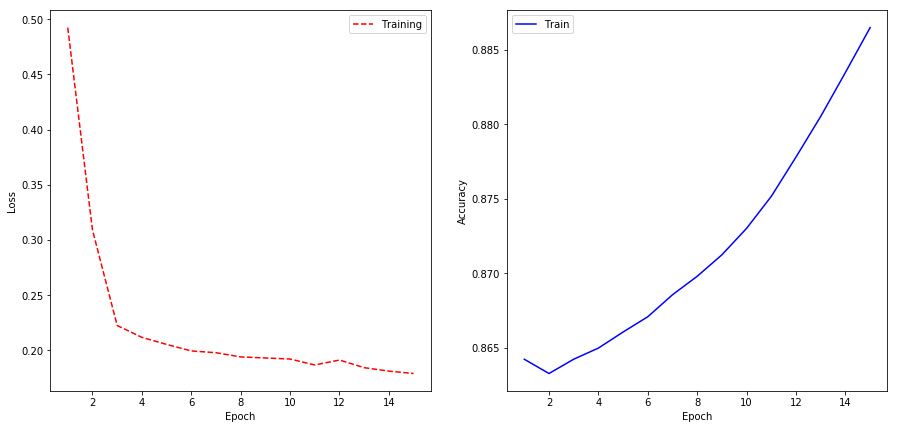

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, num_epochs + 1)

# Visualize loss history
ax1.plot(epoch_count, losses, 'r--', label='Training')
#ax1.plot(epoch_count, val_loss, 'b-', label='Validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

#ax2.plot(epoch_count, accuracies_test, 'r-', label='Test')
ax2.plot(epoch_count, accuracies_train, 'b-', label='Train')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show();

---

# Observe the recommendation results for our friends

In [31]:
def predict_movies(model, friends_id):
    movie_ids = list(df.iid.unique())
    prediction = predict(model, friends_id, movie_ids)
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [32]:
predicted_good_movies = predict_movies(model, friends_id)

In [33]:
friends_ratings = list(data_new_friends_training) #+ list(friends_movie_ratings_test)
friends_ratings_positive = []
friends_ratings_negative = []
for ur in friends_ratings:
    if ur[2] >= 4:
        friends_ratings_positive.append(ur[1])
    else:
        friends_ratings_negative.append(ur[1])

In [34]:
for m in friends_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

0.0
3.0
47.0
51.0
61.0
119.0
486.0
133.0
135.0
488.0
180.0
369.0
373.0
6.0
814.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
10.0
12.0
983.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
17.0
18.0
19.0
20.0
21.0
381.0
24.0
25.0
382.0
31.0
39.0
386.0
41.0
43.0
332.0
52.0
68.0
360.0
73.0
79.0
82.0
83.0
782.0
86.0
87.0
88.0
89.0
92.0
93.0
97.0
100.0
101.0
102.0
103.0
104.0
106.0
401.0
109.0
112.0
114.0
487.0
403.0
138.0
142.0
145.0
147.0
152.0
416.0
159.0
344.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
161.0
419.0
818.0
177.0
188.0
423.0
216.0
819.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
221.0
224.0
432.0
229.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
244.0
259.0
546.0
627.0
631.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
824.0
281.0
283.0
923.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
870.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
294.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
646.0 PREDICTED WRONG

In [35]:
for m in friends_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

333.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
123.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
539.0
490.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
5.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
378.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
779.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
379.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
380.0
28.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
29.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
383.0
42.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
49.0
55.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
81.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
94.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
96.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
362.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
363.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
400.0 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
107.0 PREDICTED W

In [36]:
friends_sparse_matrix = create_sparse_matrix(df_new_friends_train)
acc = full_auc(model, friends_sparse_matrix)
print(f"Accuracy for new user: {acc*100:.2f}%")

Accuracy for new user: 90.02%


Accuracy **93.1%** for this user is not bad, could be better! On the test set, accuracy on average is **90.9%**.

In [37]:
def predict_top_k_movies(model, friends_id, k):
    n_users, n_movies = train.shape
    prediction = predict(model, friends_id, np.arange(n_movies))
    movie_ids = df.iid.unique()
    return movie_ids[np.argsort(-prediction)][:k]

In [38]:
known_positives = df_train[(df_train.iid.isin(train.tocsr()[friends_id].indices))&(df_train.fid==friends_id)]["iid"]

k = 10
top_movies = predict_top_k_movies(model, friends_id, k)

print(f"Friends {friends_id}")
print("     Known positives:")
for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_movies:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

Friends 190
     Known positives:
        0 | toy story
        3 | twelve monkeys
        47 | the rock
        51 | lone star
        61 | the long kiss goodnight
        119 | men in black
        486 | contact
        133 | liar liar
        135 | face/off
        488 | air force one
     Recommended:
        17 | star wars
        43 | the silence of the lambs
        73 | raiders of the lost ark
        19 | pulp fiction
        360 | the princess bride
        88 | the terminator
        52 | the godfather
        21 | the shawshank redemption
        138 | schindler's list
        80 | alien


---

# LightFM

Much faster implementation that is similar doing of the code implemented above.

<div class="alert alert-success">
  <strong>Note:</strong> This will be used for prediction for movies of movies recommendation.
</div>

In [39]:
use_features = False

In [40]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [41]:
def my2csr(df):
    return sp.csr_matrix(df.values)

In [42]:
train = create_sparse_matrix(df_train)#, mat_type="ratings")

# shape [n_users, n_user_features]
friends_features = my2csr(df_friends)
item_features = my2csr(df_movies)

In [43]:
loss_type = "warp"  # "bpr"

model = LightFM(learning_rate=0.05, loss=loss_type, max_sampled=100)

if use_features:
    model.fit_partial(train, epochs=20, user_features=friends_features, item_features=item_features)
    train_precision = precision_at_k(model, train, k=10, user_features=friends_features, item_features=item_features).mean()
    
    train_auc = auc_score(model, train, user_features=friends_features, item_features=item_features).mean()
    
    print(f'Precision: train {train_precision:.2f}')
    print(f'AUC: train {train_auc:.2f}')
else:
    model.fit_partial(train, epochs=20)
    
    train_precision = precision_at_k(model, train, k=10).mean()
    
    train_auc = auc_score(model, train).mean()
    
    print(f'Precision: train {train_precision:.2f}')
    print(f'AUC: train {train_auc:.2f}')

Precision: train 0.86
AUC: train 0.91


In [44]:
friends_ratings = list(data_new_friends_training) #+ list(friends_movie_ratings_test)
friends_ratings_positive = []
friends_ratings_negative = []
for ur in friends_ratings:
    if ur[2] >= 4:
        friends_ratings_positive.append(ur[1])
    else:
        friends_ratings_negative.append(ur[1])

In [45]:
def predict_movies(model, friends_id):

    n_movies = train.shape[1]
    if use_features:
        prediction = model.predict(friends_id, np.arange(n_movies), user_features=friends_features, item_features=item_features)  #predict(model, user_id, movie_ids)
    else:
        prediction = model.predict(friends_id, np.arange(n_movies))  #predict(model, user_id, movie_ids)
    
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [46]:
predicted_good_movies = predict_movies(model, friends_id)

In [47]:
for m in friends_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

0.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
3.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
47.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
51.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
61.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
119.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
486.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
133.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
135.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
488.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
180.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
369.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
373.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
6.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
814.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
10.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
12.0 PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER
983.0 PREDICTED WRONG: SH

In [48]:
for m in friends_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

333.0
123.0
539.0
490.0
5.0
378.0
779.0
379.0
380.0
28.0
29.0
383.0
42.0
49.0
55.0
81.0
94.0
96.0
362.0
363.0
400.0
107.0
108.0
110.0
124.0
128.0
502.0
506.0
508.0
149.0
513.0
515.0
151.0
516.0
518.0
520.0
157.0
168.0
171.0
531.0
422.0
365.0
225.0
226.0
887.0
433.0
435.0
240.0
790.0
795.0
440.0
943.0
448.0
450.0
945.0
914.0
548.0
295.0
554.0
353.0
565.0
309.0
926.0
312.0
356.0
809.0
573.0
58.0
80.0
593.0
137.0
141.0
407.0
609.0
1124.0
245.0
269.0
918.0
802.0


In [49]:
friends_sparse_matrix = create_sparse_matrix(df_new_friends_train)
if use_features:
    acc = auc_score(model, friends_sparse_matrix, user_features=friends_features, item_features=item_features).mean()
else:
    acc = auc_score(model, friends_sparse_matrix).mean()

print(f"Accuracy for new friends: {acc*100:.2f}%")

Accuracy for new friends: 92.55%


In [50]:
def predict_top_k_movies(model, friends_id, k):
    n_users, n_movies = train.shape
    if use_features:
        prediction = model.predict(friends_id, np.arange(n_movies), user_features=friends_features, item_features=item_features)#predict(model, user_id, np.arange(n_movies))
    else:
        prediction = model.predict(friends_id, np.arange(n_movies))#predict(model, user_id, np.arange(n_movies))
    
    movie_ids = np.arange(train.shape[1])
    return movie_ids[np.argsort(-prediction)][:k]

In [51]:
k = 10
friends_id = friends_id
movie_ids = np.arange(train.shape[1])

n_users, n_items = train.shape

known_positives = movie_ids[train.tocsr()[friends_id].indices]

if use_features:
    scores = model.predict(friends_id, np.arange(n_items), user_features=friends_features, item_features=item_features)
else:
    scores = model.predict(friends_id, np.arange(n_items))

top_items = movie_ids[np.argsort(-scores)]

print(f"Friends {friends_id}")
print("     Known positives:")

for x in known_positives[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_items[:k]:
    print(f"        {df[df.iid==x]['iid'].iloc[0]} | {df[df.iid==x]['title'].iloc[0]}" )

Friends 190
     Known positives:
        0 | toy story
        3 | twelve monkeys
        6 | the usual suspects
        10 | apollo 13
        12 | crimson tide
        17 | star wars
        18 | outbreak
        19 | pulp fiction
        20 | quiz show
        21 | the shawshank redemption
     Recommended:
        17 | star wars
        73 | raiders of the lost ark
        21 | the shawshank redemption
        6 | the usual suspects
        31 | the fugitive
        41 | terminator 2: judgment day
        43 | the silence of the lambs
        196 | it's a wonderful life
        52 | the godfather
        25 | forrest gump
